Code testing for https://github.com/pymc-devs/pymc3/pull/2986

In [1]:
import numpy as np
import pymc3 as pm
import pymc3.distributions.transforms as tr
import theano.tensor as tt
from theano.scan_module import until
import theano
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Polar transformation
    

In [2]:
# Polar to Cartesian
def backward(y):
    # y = [r, theta]
    x = tt.zeros(y.shape)
    x = tt.inc_subtensor(x[0], y[0]*tt.cos(y[1]))
    x = tt.inc_subtensor(x[1], y[0]*tt.sin(y[1]))
    return x

def forward(x):
    # y = [r, theta]
    y = tt.zeros(x.shape)
    y = tt.inc_subtensor(y[0], tt.sqrt(tt.square(x[0]) + tt.square(x[1])))
    if y[0] != 0:
        if x[1] < 0:
            theta = -tt.arccos(x[0]/y[0])
        else:
            theta = tt.arccos(x[0]/y[0])
    y = tt.inc_subtensor(y[1], theta)
    return y

In [3]:
y = tt.vector('polar')
y.tag.test_value=np.asarray([1., np.pi/2])

In [4]:
f_inv = backward(y)
J, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x),
                       sequences=tt.arange(f_inv.shape[0]),
                       non_sequences=[f_inv, y])

In [5]:
Jacob_f1 = theano.function([y], J)

In [6]:
Jacob_f1(np.asarray([1., np.pi/2]))

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [7]:
J2 = pm.theanof.jacobian(f_inv, [y])
Jacob_f2 = theano.function([y], J2)
Jacob_f2(np.asarray([1., np.pi/2]))

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [8]:
%timeit Jacob_f1(np.asarray([1., np.pi/2]))
%timeit Jacob_f2(np.asarray([1., np.pi/2]))

94.5 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
107 µs ± 4.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
class VectorTransform(tr.Transform): 
 
    def jacobian_det(self, x): 
        f_inv = self.backward(x) 
        J, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x), 
                           sequences=tt.arange(f_inv.shape[0]), 
                           non_sequences=[f_inv, x]) 
        return tt.log(tt.abs_(tt.nlinalg.det(J))) 

In [11]:
class Nealfun(VectorTransform):
    name = "Neal_funnel"

    def backward(self, y):
        x = tt.zeros(y.shape)
        x = tt.inc_subtensor(x[0], y[0] / 3.)
        x = tt.inc_subtensor(x[1:], y[1:] / tt.exp(y[0] / 2))
        return x

    def forward(self, x):
        y = tt.zeros(x.shape)
        y = tt.inc_subtensor(y[0], x[0] * 3.)
        y = tt.inc_subtensor(y[1:], tt.exp(x[0] * 3. / 2) * x[1:])
        return y

In [12]:
y = tt.vector('y')
y.tag.test_value = np.zeros(101)

In [13]:
nealfun = Nealfun()
f_inv = nealfun.backward(y)

J1, _ = theano.scan(lambda i, f, x: tt.grad(f[i], x),
                       sequences=tt.arange(f_inv.shape[0]),
                       non_sequences=[f_inv, y])
Jacob_f1 = theano.function([y], J1)

J2 = pm.theanof.jacobian(f_inv, [y])
Jacob_f2 = theano.function([y], J2)

In [14]:
%timeit Jacob_f1(np.zeros(101))
%timeit Jacob_f2(np.zeros(101))

1.32 ms ± 5.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.36 ms ± 23.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Copulas
Background reading http://twiecki.github.io/blog/2018/05/03/copulas/  
More information https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Copula.ipynb

In [15]:
import scipy.stats as st
norm = st.norm()

In [16]:
def norm_cdf(x):
    return x_unif


def copulas_forward_func(nsample, cov, marg1_ppf, marg2_ppf):
    mvnorm = st.multivariate_normal(mean=[0, 0], cov=cov)
    # Generate random samples from multivariate normal with correlation .5
    x = mvnorm.rvs(nsample)
    x_unif = norm.cdf(x)
    x_trans = np.vstack([marg1_ppf(x_unif[:, 0]), marg2_ppf(x_unif[:, 1])]).T
    return x_trans, x_unif, x

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


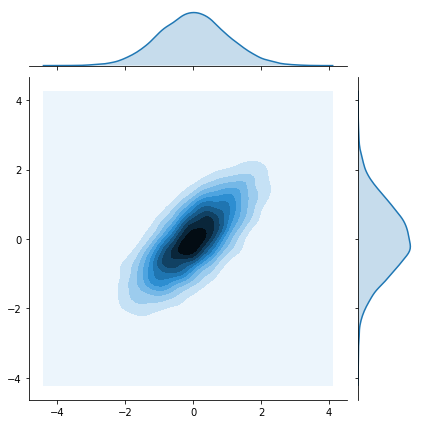

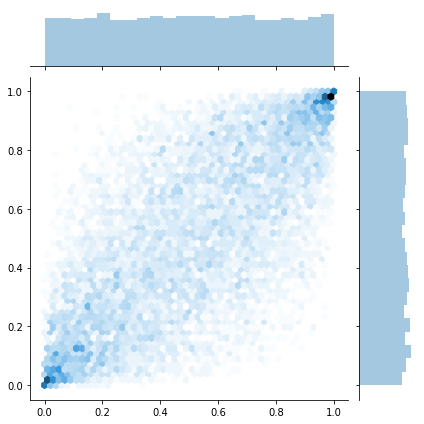

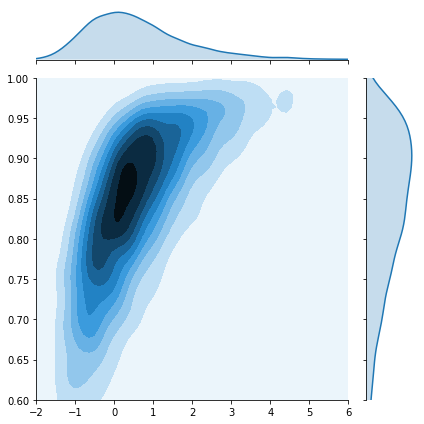

In [17]:
cov = np.asarray([[1., 0.725], [0.725, 1.]])
marg1_ppf = st.gumbel_r().ppf
marg2_ppf = st.beta(a=10, b=2).ppf
x_trans, x_unif, x = copulas_forward_func(10000, cov, marg1_ppf, marg2_ppf)

sns.jointplot(x[:, 0], x[:, 1], kind='kde', stat_func=None)
sns.jointplot(x_unif[:, 0], x_unif[:, 1], kind='hex',
              stat_func=None, joint_kws=dict(gridsize=50))
sns.jointplot(x_trans[:, 0], x_trans[:, 1], kind='kde',
              stat_func=None, xlim=(-2, 6), ylim=(.6, 1.0),)
plt.tight_layout()

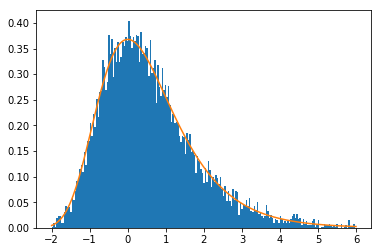

In [18]:
xrange = np.linspace(-2, 6, 200)
plt.hist(x_trans[:, 0], xrange, density='pdf')
plt.plot(xrange, st.gumbel_r.pdf(xrange));

In [19]:
def gumbel_cdf(value, mu, beta):
    return tt.exp(-tt.exp(-(value-mu)/beta))

Beta CDF

In [20]:
from theano.scan_module import until

In [21]:
max_iter=200
value_, a, b = x_trans[:, 1], 10., 2.
value = theano.shared(np.reshape(value_, (1,len(value_))))

EPS = 3.0e-7
qab = a + b
qap = a + 1.0
qam = a - 1.0

def _step(i, az, bm, am, bz):

    tem = i + i
    d = i * (b - i) * value / ((qam + tem) * (a + tem))
    d =- (a + i) * i * value / ((qap + tem) * (a + tem))

    ap = az + d * am
    bp = bz + d * bm

    app = ap + d * az
    bpp = bp + d * bz

    aold = az

    am = ap / bpp
    bm = bp / bpp
    az = app / bpp

    bz = tt.ones_like(bz)

    return (az, bm, am, bz), until(tt.sum(tt.lt(tt.abs_(az - aold), (EPS * tt.abs_(az)))))

(az, bm, am, bz), _ = theano.scan(_step,
            sequences=[tt.arange(1, max_iter)],
            outputs_info=[tt.ones_like(value),
                          tt.ones_like(value), 
                          tt.ones_like(value), 
                          1. - qab * value / qap])

In [22]:
def cont_fraction_beta(value_, a, b, max_iter=500):
    '''Evaluates the continued fraction form of the incomplete Beta function.
    Derived from implementation by Ali Shoaib (https://goo.gl/HxjIJx).
    '''

    EPS = 1.0e-20
    qab = a + b
    qap = a + 1.0
    qam = a - 1.0
    value = theano.shared(value_)

    def _step(i, az, bm, am, bz):

        tem = i + i
        d = i * (b - i) * value / ((qam + tem) * (a + tem))
        d = - (a + i) * i * value / ((qap + tem) * (a + tem))

        ap = az + d * am
        bp = bz + d * bm

        app = ap + d * az
        bpp = bp + d * bz

        aold = az

        am = ap / bpp
        bm = bp / bpp
        az = app / bpp

        bz = tt.ones_like(bz)

        return (az, bm, am, bz), until(tt.sum(tt.lt(tt.abs_(az - aold), (EPS * tt.abs_(az)))))

    (az, bm, am, bz), _ = theano.scan(_step,
                                      sequences=[tt.arange(1, max_iter)],
                                      outputs_info=[tt.ones_like(value),
                                                    tt.ones_like(value),
                                                    tt.ones_like(value),
                                                    1. - qab * value / qap])

    return az[-1]


def beta_cdf(value, a, b):
    log_beta = tt.gammaln(a+b) - tt.gammaln(a) - tt.gammaln(b)
    log_beta += a * tt.log(value) + b * tt.log(1 - value)
    cdf = tt.switch(
        tt.lt(value, (a + 1) / (a + b + 2)),
        tt.exp(log_beta) * cont_fraction_beta(value, a, b) / a,
        1. - tt.exp(log_beta) * cont_fraction_beta(1. - value, b, a) / b
    )
    return cdf

In [23]:
def normal_ppf(value):
    return -np.sqrt(2.) * tt.erfcinv(2. * value)

In [24]:
functmp = theano.function([],
                          tt.stack([gumbel_cdf(x_trans[:, 0], 0., 1.),
                                    beta_cdf(x_trans[:, 1], 10., 2.)]).T
                          )
x_ = functmp()
x_

array([[0.71456904, 0.88643962],
       [0.20226578, 0.62294611],
       [0.11846792, 0.19264947],
       ...,
       [0.63552314, 0.87672182],
       [0.17508077, 0.055997  ],
       [0.95955294, 0.86216312]])

In [25]:
x_unif

array([[0.71456904, 0.88795433],
       [0.20226578, 0.65367965],
       [0.11846792, 0.14384961],
       ...,
       [0.63552314, 0.87855861],
       [0.17508077, 0.04859346],
       [0.95955294, 0.86455638]])

In [26]:
np.sum(~np.isfinite(x_))

0

In [27]:
with pm.Model() as model:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))
    a = pm.HalfNormal('alpha', 5., testval=10.)
    b = pm.HalfNormal('beta', 2.5, testval=2.)
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(x_trans[:, 0], loc, scale),
                  beta_cdf(x_trans[:, 1], a, b)]).T
    )
    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.Beta('marg1', a, b, observed=x_trans[:, 1])

ValueError: array must not contain infs or NaNs

The beta CDF does not quite work - use another distribution instead

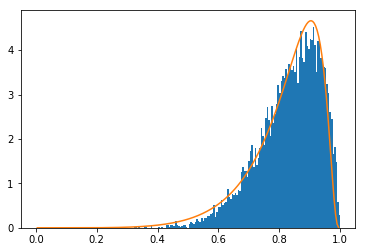

In [28]:
from scipy.special import logit
xrange = np.linspace(0, 1, 200)
plt.hist(x_trans[:, 1], xrange, density='pdf')
logitnormpdf = st.norm.pdf(logit(xrange), loc=1.725, scale=.8) * 1/(xrange * (1-xrange))
plt.plot(xrange, logitnormpdf);

In [29]:
def logitnorm_cdf(value, mu, sd):
    return .5 + .5*(tt.erf((logit(value)-mu)/(np.sqrt(2)*sd)))

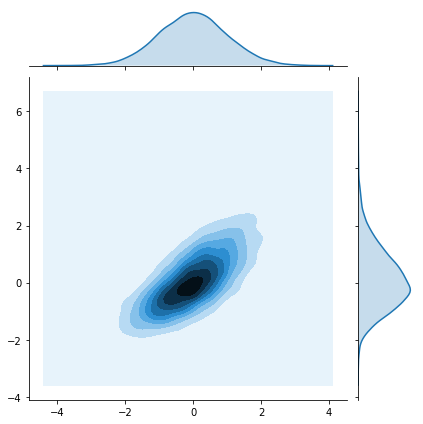

In [30]:
tr_func = normal_ppf(
    tt.stack([gumbel_cdf(x_trans[:, 0], 0., 1.),
              logitnorm_cdf(x_trans[:, 1], 1.725, .8)]).T
)
functmp = theano.function([], tr_func)
x_ = functmp()
sns.jointplot(x_[:, 0], x_[:, 1], kind='kde', stat_func=None);

In [31]:
np.sum(~np.isfinite(x_[:, 1]))

0

In [32]:
with pm.Model() as model:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)
    mu = pm.Normal('mu', 1., 1., testval=1.725)
    sd = pm.HalfNormal('sd', .5, testval=.8)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(x_trans[:, 0], loc, scale),
                  logitnorm_cdf(x_trans[:, 1], mu, sd)]).T
    )

    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.LogitNormal('marg1', mu, sd, observed=x_trans[:, 1])

In [33]:
with model:
    map1 = pm.find_MAP()
map1

logp = -26,982, ||grad|| = 997.35: 100%|██████████| 19/19 [00:00<00:00, 186.55it/s]  


{'cov': array([[1.       , 0.8968124],
        [0.8968124, 1.       ]]),
 'loc': array(-0.16837774),
 'mu': array(1.82822079),
 'r': array(0.8968124),
 'r_interval__': array(2.91138141),
 'scale': array(1.68448407),
 'scale_log__': array(0.52145932),
 'sd': array(1.42803229),
 'sd_log__': array(0.35629747)}

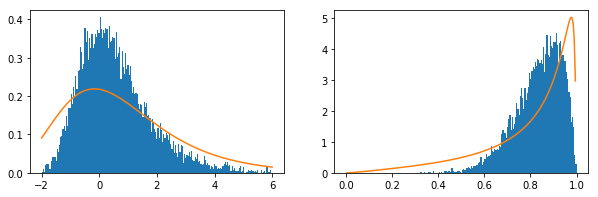

In [34]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map1['loc'], scale=map1['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
logitnormpdf = st.norm.pdf(logit(x1), loc=map1['mu'], scale=map1['sd']) * 1/(x1 * (1-x1))
ax[1].plot(x1, logitnormpdf);

In [35]:
with pm.Model() as model_marg:
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)
    mu = pm.Normal('mu', 1., 1., testval=1.725)
    sd = pm.HalfNormal('sd', .5, testval=.8)

    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.LogitNormal('marg1', mu, sd, observed=x_trans[:, 1])
    map_ = pm.find_MAP()

logp = -6,591.9, ||grad|| = 2,463: 100%|██████████| 9/9 [00:00<00:00, 1115.28it/s]


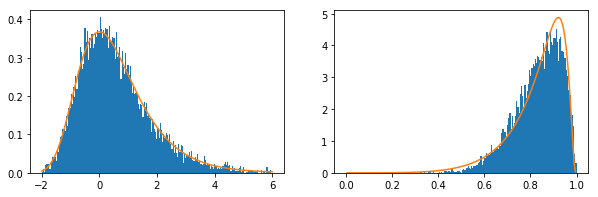

In [36]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map_['loc'], scale=map_['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
logitnormpdf = st.norm.pdf(logit(x1), loc=map_['mu'], scale=map_['sd']) * 1/(x1 * (1-x1))
ax[1].plot(x1, logitnormpdf);

Kumaraswamy distribution

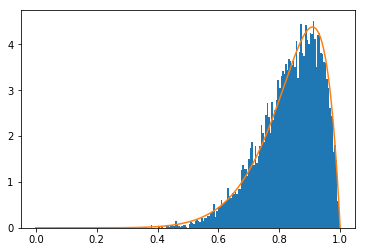

In [37]:
from scipy.special import logit
xrange = np.linspace(0, 1, 200)
plt.hist(x_trans[:, 1], xrange, density='pdf')
Kumaraswamypdf = lambda x, a, b: a*b*np.power(x, a-1)*np.power(1-np.power(x, a), b-1)
plt.plot(xrange, Kumaraswamypdf(xrange, 8, 2));

In [38]:
def Kumaraswamy_cdf(value, a, b):
    return 1 - tt.pow(1 - tt.pow(value, a), b)

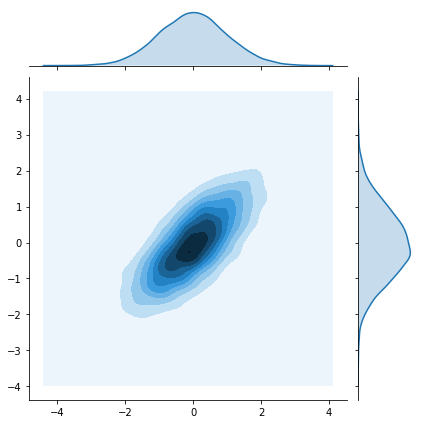

In [39]:
tr_func = normal_ppf(
    tt.stack([gumbel_cdf(x_trans[:, 0], 0., 1.),
              Kumaraswamy_cdf(x_trans[:, 1], 8, 2)]).T
)
functmp = theano.function([], tr_func)
x_ = functmp()
sns.jointplot(x_[:, 0], x_[:, 1], kind='kde', stat_func=None);

In [40]:
np.sum(~np.isfinite(x_[:, 1]))

0

In [41]:
with pm.Model() as model:
    # r∼Uniform(−1,1)
    r =  pm.Uniform('r',lower=-1, upper=1)

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))

    a = pm.HalfNormal('alpha', 5., testval=10.)
    b = pm.HalfNormal('beta', 2.5, testval=2.)
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(x_trans[:, 0], loc, scale),
                  Kumaraswamy_cdf(x_trans[:, 1], a, b)]).T
    )

    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.Kumaraswamy('marg1', a, b, observed=x_trans[:, 1])

In [42]:
with model:
    map1 = pm.find_MAP()
map1

logp = -26,765, ||grad|| = 1,600.5: 100%|██████████| 20/20 [00:00<00:00, 132.50it/s]  


{'alpha': array(3.79772796),
 'alpha_log__': array(1.33440298),
 'beta': array(0.8792569),
 'beta_log__': array(-0.12867816),
 'cov': array([[1.        , 0.89539346],
        [0.89539346, 1.        ]]),
 'loc': array(-0.16498078),
 'r': array(0.89539346),
 'r_interval__': array(2.89697561),
 'scale': array(1.66830622),
 'scale_log__': array(0.51180887)}

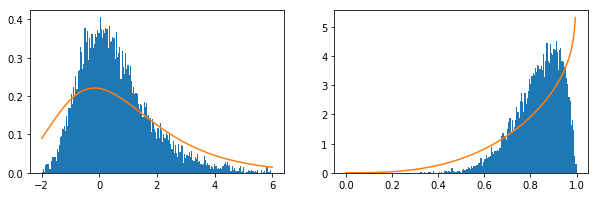

In [43]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map1['loc'], scale=map1['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
ax[1].plot(x1, Kumaraswamypdf(x1, map1['alpha'], map1['beta']));

In [44]:
with pm.Model() as model_marg:
    a = pm.HalfNormal('alpha', 5., testval=10.)
    b = pm.HalfNormal('beta', 2.5, testval=2.)
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)

    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.Kumaraswamy('marg1', a, b, observed=x_trans[:, 1])
    map_ = pm.find_MAP()

logp = -6,743.2, ||grad|| = 5,464: 100%|██████████| 10/10 [00:00<00:00, 379.84it/s]


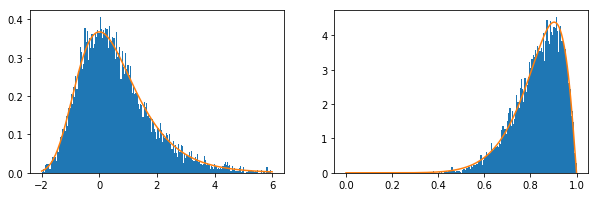

In [45]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map_['loc'], scale=map_['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
ax[1].plot(x1, Kumaraswamypdf(x1, map_['alpha'], map_['beta']));

logp = -27,754, ||grad|| = 17.321: 100%|██████████| 15/15 [00:00<00:00, 144.38it/s]  


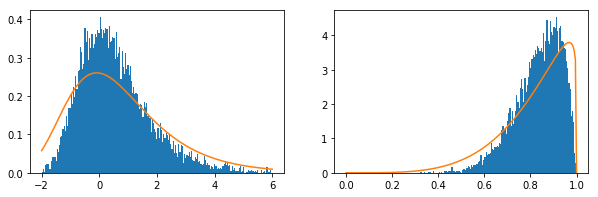

In [46]:
with pm.Model() as model_marg2:
    # r∼Uniform(−1,1)
    r = 0.725

    cov = pm.Deterministic('cov', 
                           tt.stacklists([[1., r],
                                          [r, 1.]]))

    a = pm.HalfNormal('alpha', 5., testval=10.)
    b = pm.HalfNormal('beta', 2.5, testval=2.)
    loc = pm.Normal('loc', 0., 5., testval=0.)
    scale = pm.HalfNormal('scale', 2.5, testval=1.)

    tr_func = normal_ppf(
        tt.stack([gumbel_cdf(x_trans[:, 0], loc, scale),
                  Kumaraswamy_cdf(x_trans[:, 1], a, b)]).T
    )

    pm.MvNormal('obs', np.zeros(2), cov=cov, observed=tr_func)
    pm.Gumbel('marg0', loc, scale, observed=x_trans[:, 0])
    pm.Kumaraswamy('marg1', a, b, observed=x_trans[:, 1])
    map_ = pm.find_MAP()

_, ax = plt.subplots(1, 2, figsize=(10, 3))
x0 = np.linspace(-2, 6, 200)
ax[0].hist(x_trans[:, 0], x0, density='pdf')
ax[0].plot(x0, st.gumbel_r.pdf(x0, loc=map_['loc'], scale=map_['scale']))

x1 = np.linspace(0, 1, 200)
ax[1].hist(x_trans[:, 1], x1, density='pdf')
ax[1].plot(x1, Kumaraswamypdf(x1, map_['alpha'], map_['beta']));